In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../source/")
from fuzzy.clustering import *
from sklearn.datasets import load_iris, load_breast_cancer, load_digits, load_wine
from matplotlib.colors import LinearSegmentedColormap, to_rgba
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
from matplotlib.colors import Normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

palette = mpl.colormaps["Blues"]
errors = mpl.colormaps["Reds"]

In [2]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import pairwise_distances

def remap_labels(X, labels1, labels2):
    costs = np.zeros((len(np.unique(labels1)), len(np.unique(labels2))))
    for i in np.unique(labels1):
        X1 = X[labels1 == i,:]
        
        for j in np.unique(labels2):
            X2 = X[labels2 == j,:]
            dists = pairwise_distances(X1, X2)
            row_ind, col_ind = linear_sum_assignment(dists)
            costs[i,j]  = dists[row_ind, col_ind].sum()
            
    return linear_sum_assignment(costs)

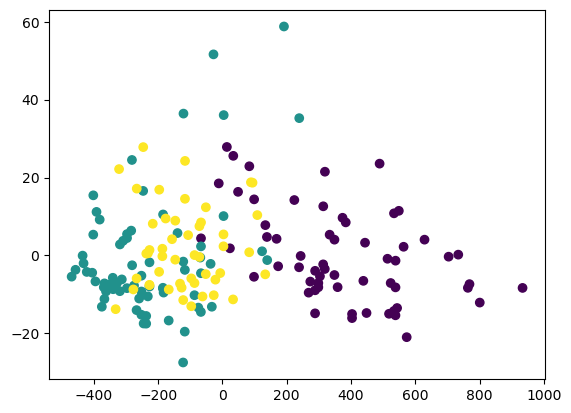

In [3]:
X, y = load_wine(return_X_y=True)

pca = PCA(n_components=2)
X_red = pca.fit_transform(X)

classes = len(np.unique(y))

plt.scatter(X_red[:,0], X_red[:, 1], c=y)

# Fuzzy C-Means

In [4]:
fcm = FuzzyCMeans(n_clusters=classes, fuzzifier=2)
fcm.fit(X)
y_pred = fcm.predict(X)
y_proba = fcm.predict_proba(X)

Text(0.5, 1.0, 'Membership')

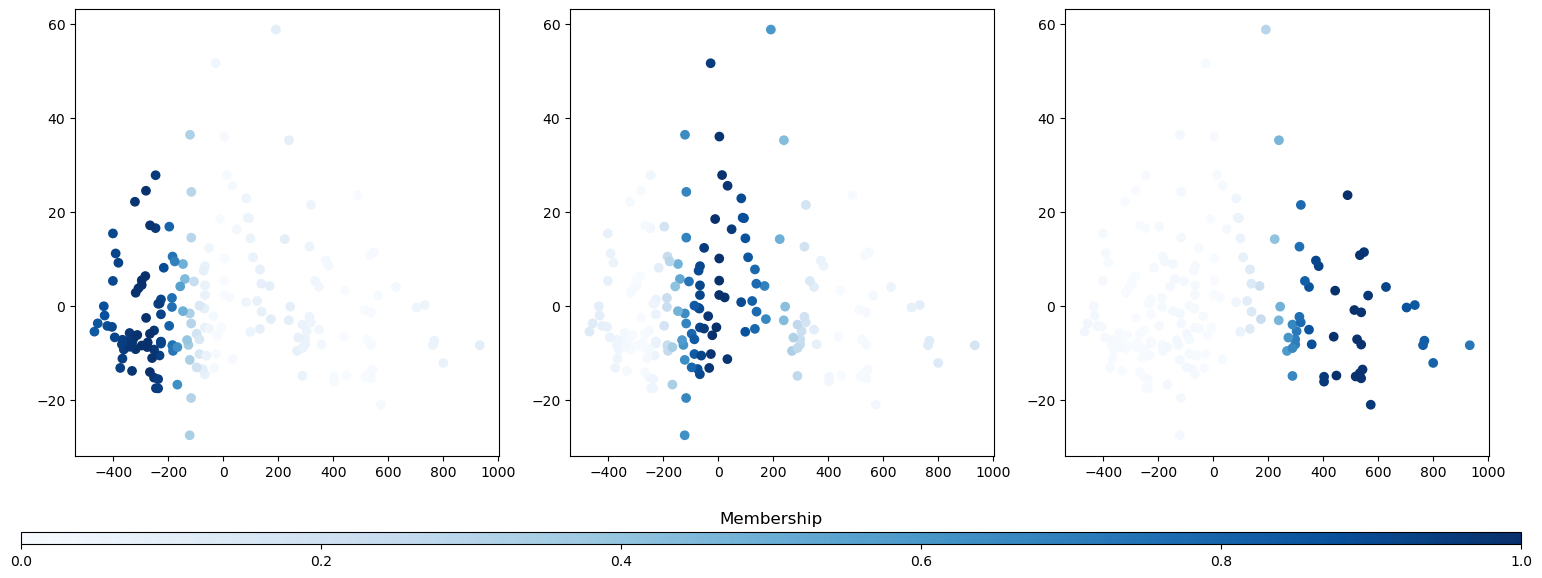

In [5]:
fig, axs = plt.subplots(1,classes, figsize=(5*classes,5))

for i in range(classes):
    axs[i].scatter(X_red[:,0], X_red[:, 1], c=y_proba[i].memberships, cmap=palette)

fig.tight_layout()

im=ScalarMappable(cmap=palette, norm=Normalize(0,1))
cbar_ax = fig.add_axes([0, -0.1, 1, 0.025])
fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', cax=cbar_ax)
cbar_ax.set_title("Membership")


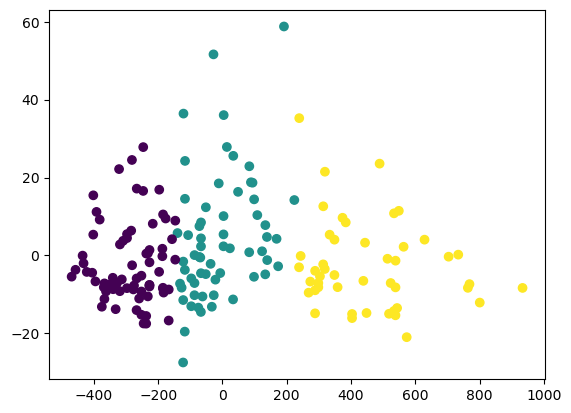

In [6]:
plt.scatter(X_red[:,0], X_red[:, 1], c=y_pred)

Accuracy 0.69


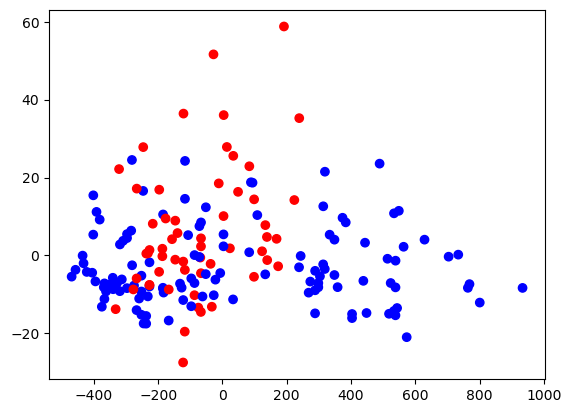

In [7]:
row_ind, col_ind = remap_labels(X, y_pred, y)
row_ind, col_ind

y_remap = [col_ind[i] for i in y_pred]
plt.scatter(X_red[:,0], X_red[:, 1], c=["b" if v else "r" for v in (y_remap==y)])
print("Accuracy %.2f" % (len(y[y==y_remap])/len(y)))

Weighted Accuracy 0.65


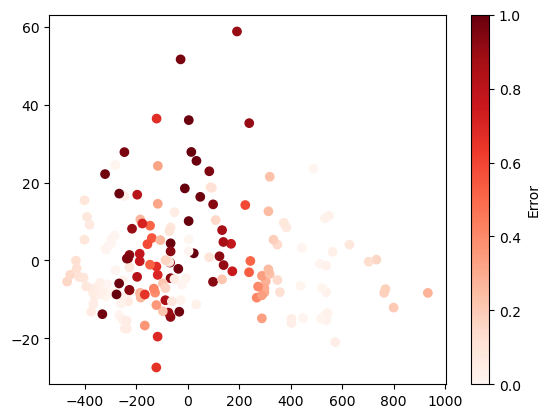

In [8]:
plt.figure()
proba_remap = y_proba[np.argsort(col_ind)]
errs = [1-proba_remap[y[i]].memberships[i] for i in range(len(y))]
plt.scatter(X_red[:,0], X_red[:, 1], c = errs, cmap=errors)

im=ScalarMappable(cmap=errors, norm=Normalize(0,1))
plt.colorbar(im, ax=plt.gca(), label="Error")
print("Weighted Accuracy %.2f" % (1 - np.sum(errs)/X.shape[0]))